# OCOM510M Data Science: Assessment 2

Student ID: 202031023

## 1. Aims, objectives and plan
Although we have already stated what is required, please formally state the aims and objectives of the project in your own words. 100-200 words.

Please demonstrate how you have conducted the project with a simple Gantt chart.

## 2. Understanding the case study

    ###  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the client's needs. (You can include more than four points.) 200-300 words.

1.
1. 
1. 
1. 



## 3. Pre-processing applied

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Merging, pivoting and melting, if necessary
- Preparing the labels appropriately, if necessary
- Dealing with missing values (imputation, filtering) without leaking, if necessary
- Dealing with duplicate values, if necessary
- Scaling, without leaking, if necessary
- Dealing with correlation and collinearity, if necessary
- Variance analysis, if necessary
- Appropriate feature selection such as RFE, if necessary
- Appropriate feature extraction, if necessary
- Identifying and dealing with class imbalance, if necessary
- Identifying and dealing with outliers, if necessary
- Categorical and numerical encoding if necessary
- Other pre-processing

#### 3.1 Imports
Importing allowed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 3.2 Load data sets
Loading data sets raw and verify how they look like.


In [2]:
# 1. load datasets
data_dir = 'TrainData/'
demographics = pd.read_csv(data_dir + 'Train_Demographics.csv')
claim = pd.read_csv(data_dir + 'Train_Claim.csv')
policy = pd.read_csv(data_dir + 'Train_Policy.csv')
vehicle = pd.read_csv(data_dir + 'Train_Vehicle.csv')
target = pd.read_csv(data_dir + 'Traindata_with_Target.csv')

# Trainingdata_without_Target.xlsx is skipped, using Traindata_with_Target.csv with target column
# test_target = pd.read_excel(data_dir + 'Traindata_without_Target.xlsx', sheet_name=1)

# check dimensions of datasets
print(f"Train_Demographics.csv: {demographics.shape}")
print(f"Train_Claim.csv: {claim.shape}")
print(f"Train_Policy.csv: {policy.shape}")
print(f"Train_Vehicle.csv: {vehicle.shape}")
print(f"Traindata_with_Target.csv: {target.shape}")

Train_Demographics.csv: (28836, 10)
Train_Claim.csv: (28836, 19)
Train_Policy.csv: (28836, 10)
Train_Vehicle.csv: (115344, 3)
Traindata_with_Target.csv: (28836, 2)


At first glance the output shows that dataset vehicle contains considerable more rows and likely needs to be reworked. All other csv files seem to have consistent rows. But first an analysis on missing values will be performed.

#### 3.3 Dealing with missing values
Based on AttributeInformation.pdf there is a set of custom missing values which need to be observed. The findings in this step are:
- AttributeInformation.pdf is inconsistent with the real missing values in the file.
- Predefined missing values e.g. -1, -5 could be used in other features as meaningful values within the same DataFrame and therefore could be selected as missing values although they are not. This is not the case.
- Pandas loads by default "NA" as NaN.
- Due to anonymization not all features are listed, e.g. TotalCharges is not present in the csv file.
- Country contains NaN values


In [3]:
# Check missing values in datasets and check if other columns other than the ones specified in AttributeInformation have any of the pre-defined missing values.

# Train_Policy.csv
cols_with_minus_one = (policy == -1).sum().sort_values(ascending=False)
cols_with_minus_one[cols_with_minus_one > 0]

PolicyAnnualPremium    141
dtype: int64

In [4]:
# Train_Policy.csv

# TotalCharges feature is not present in Train_Policy.csv despite it is described AttributeInformation.pdf
cols_with_MISSINGVAL = (policy == "MISSINGVAL").sum()
cols_with_MISSINGVAL[cols_with_MISSINGVAL > 0]

Series([], dtype: int64)

In [5]:
# Train_Demographics.csv
na_counts = demographics.isna().sum()
na_counts[na_counts > 0]

InsuredGender    30
Country           2
dtype: int64

In [6]:
# Train_Claim.csv
claim_with_minus_five = (claim == -5).sum()
claim_with_minus_five[claim_with_minus_five > 0]

IncidentTime    31
dtype: int64

In [7]:
# Train_Claim.csv
claim_with_MISSINGVALUE = (claim == 'MISSINGVALUE').sum()
claim_with_MISSINGVALUE[claim_with_MISSINGVALUE > 0]

Witnesses    46
dtype: int64

In [8]:
# Train_Claim.csv
claim_with_MISSEDDATA = (claim == 'MISSEDDATA').sum()
claim_with_MISSEDDATA[claim_with_MISSEDDATA > 0]

AmountOfTotalClaim    50
dtype: int64

In [9]:
# Train_Claim.csv
claim_with_qmarks = (claim == "?").sum()
claim_with_qmarks[claim_with_qmarks > 0]

TypeOfCollission     5162
PropertyDamage      10459
PoliceReport         9805
dtype: int64

In [10]:
# Train_Vehicle.csv
vehicle_with_missing_vals = (vehicle == "???").sum()
vehicle_with_missing_vals[vehicle_with_missing_vals > 0]

VehicleAttributeDetails    50
dtype: int64

In the next step I pass the na_values specific per dataset, and explicitly intend to avoid passing a python list of missing value, this in order to prevent accidental corruption by marking actual e.g. -1 or -5 values as missing values in other datasets or even in the same dataset but different feature (in the cells above it was check that current dataset does not contain values markes as missing values in other features with meaning intent). So I opted to pass the specific missing value token per dataset.

In [11]:
# Reload datasets and correct for missing values as per AttributeInformation.pdf definition
demographics = pd.read_csv(data_dir + 'Train_Demographics.csv', na_values=['NA']) # NA was automatically converted by Pandas however for illustration purposes
claim = pd.read_csv(data_dir + 'Train_Claim.csv', na_values=['?','-5', 'MISSINGVALUE', 'MISSEDDATA'])
policy = pd.read_csv(data_dir + 'Train_Policy.csv', na_values=['NA', '-1', 'MISSINGVAL'])
vehicle_raw = pd.read_csv(data_dir + 'Train_Vehicle.csv', na_values=['???'])

# Check if missing values were marked as NaN. Not displaying all for simplicity but this could easily checked further
print(f"PolicyAnnualPremium NaN count: {policy['PolicyAnnualPremium'].isna().sum()}")
print(f"PropertyDamage NaN count: {claim['PropertyDamage'].isna().sum()}")

# etc.

PolicyAnnualPremium NaN count: 141
PropertyDamage NaN count: 10459


#### 3.4 Pivoting and Merging
In Section 3.2, during data loading, one of the findings was that the dataset Train_Vehicle.csv required restructuring. The vehicle data is stored in an attribute–value pair (long) format. To ensure that each customer is represented by a single row with separate columns for attributes such as VehicleID and VehicleModel, the dataset was converted from long format to wide format, a process commonly referred to as pivoting.

In [13]:
# Understand which attributes exist in dataset vehicle
vehicle_raw.VehicleAttribute.unique()
## 4 different attributes

array(['VehicleID', 'VehicleModel', 'VehicleMake', 'VehicleYOM'],
      dtype=object)

In [27]:
# Pivot the vehicle data from long to wide format to reflect previous attributes
vehicle = vehicle_raw.pivot(
    index='CustomerID',
    columns='VehicleAttribute',
    values='VehicleAttributeDetails'
).reset_index()

vehicle.columns.name = None
# Check the shape of the new dataset
print("Vehicle Shape:", vehicle.shape)
vehicle.head()

Vehicle Shape: (28836, 5)


,CustomerID,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10000,Vehicle26917,Audi,A5,2008
1,Cust10001,Vehicle15893,Audi,A5,2006
2,Cust10002,Vehicle5152,Volkswagen,Jetta,1999
3,Cust10003,Vehicle37363,Volkswagen,Jetta,2003
4,Cust10004,Vehicle28633,Toyota,CRV,2010


Next, is time to consolidate all datasets by merging into one single dataframe. This dataframe will later be reworked to select relevant features for model fitting. I have implemented an audit_merge helper function to verify that the CustomerID keys match across all files before merging. In this specific use case, the target and source datasets are synchronized, however, this audit step was important for identifying potential data gaps. By using an Inner Join strategy, I ensure that the final dataset only contains records with a complete set of features from all four source files.

In [15]:
# Check that there are no data gaps between target and source datasets.
# For this Case Study there are non and all CustomerID keys match accrross files.
# For simplicity this function is invoked once.
def audit_merge(target_df, source_df):
    target_ids = set(target_df['CustomerID'])
    source_ids = set(source_df['CustomerID'])

    # 1. IDs in target_df but MISSING in source_df
    missing_in_demo = target_ids - source_ids

    # 2. IDs in source_df but MISSING in target_df
    missing_in_target = source_ids - target_ids

    # 3. The Intersection (IDs that exist in both)
    common_ids = target_ids.intersection(source_ids)
    print("---- Audit analysis ----")
    print(f"IDs in Target: {len(target_ids)}")
    print(f"IDs in Source: {len(source_ids)}")
    print(f"Common IDs: {len(common_ids)}")
    print(f"Missing in Source: {len(missing_in_demo)}")
    print(f"Missing in Target: {len(missing_in_target)}")
    print()

In [36]:
# Perform merges sequentially

# Start with the Target dataset
data_merged = target.copy()

# Merge with Demographics
audit_merge(data_merged, demographics) # invoking once to avoid clutter. However, this operation was checked in upcoming merges leading to no gaps.
data_merged = data_merged.merge(demographics, on='CustomerID', how='inner')

# Merge with Policy
data_merged = data_merged.merge(policy, on='CustomerID', how='inner')

# Merge with Claim data
data_merged = data_merged.merge(claim, on='CustomerID', how='inner')

# 4. Merge with the Pivoted Vehicle data
data_merged = data_merged.merge(vehicle, on='CustomerID', how='inner')

# Convert 'ReportedFraud' (Target) to 1 (Fraud) and 0 (Non-Fraud)
data_merged['ReportedFraud_Numeric'] = data_merged['ReportedFraud'].map({'Y': 1, 'N': 0})

# Drop the original 'ReportedFraud' column
data_merged.drop('ReportedFraud', axis=1, inplace=True)

# Check the first version datamerged rows and column
print("---- Data merged ----")
data_merged.shape

---- Audit analysis ----
IDs in Target: 28836
IDs in Source: 28836
Common IDs: 28836
Missing in Source: 0
Missing in Target: 0

---- Data merged ----


(28836, 42)

#### 3.5 Removing noisy attributes
#### Removal of Noisy Attributes
"To improve model generalization and reduce overfitting, unique identifiers such as CustomerID, InsurancePolicyNumber, and VehicleID were removed. These attributes contain high-cardinality data that does not possess predictive power for fraud detection. Additionally, IncidentAddress was excluded as the raw string data would act as noise without complex geospatial encoding."

#### Removal of Synonymous/Redundant Attributes:

"The attribute Country was identified as synonymous with a constant value (99.9% 'India') and thus removed due to lack of variance. Furthermore, raw date fields (DateOfPolicyCoverage, DateOfIncident) were removed to prevent redundancy, as temporal information is already captured in the CustomerLoyaltyPeriod and VehicleYOM attributes."

In [66]:
# 1. Final Drop List (Noisy + Synonymous + Highly Collinear)
# We drop the sub-claims because they are redundant with 'AmountOfTotalClaim'
cols_to_drop = [
    'CustomerID', 'InsurancePolicyNumber', 'InsuredZipCode',
    'IncidentAddress', 'VehicleID', 'Country',
    'DateOfPolicyCoverage', 'DateOfIncident', 'VehicleModel',
]

# 2. Separate features and target
X = data_merged.drop(columns=cols_to_drop + ['ReportedFraud_Numeric'])
y = data_merged['ReportedFraud_Numeric']

# 3. Categorize for the Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Total features retained for Pipeline: {len(X.columns)}")

Total features retained for Pipeline: 32


#### 3.6 Colinearity

A correlation analysis was performed on all numerical attributes. As the the matrix depicts high levels of correlation are found at the bottom-right corner since the total claim is just the sum of the others, keeping all four gives the model redundant information. Therefore AmountOfTotalClaim was retained as the primary indicator of claim magnitude while sub-components were removed due to redundancy

CustomerLoyaltyPeriod and InsuredAge is expected, older customers have had more loyalty years but it is not seen as a redundancy factor.

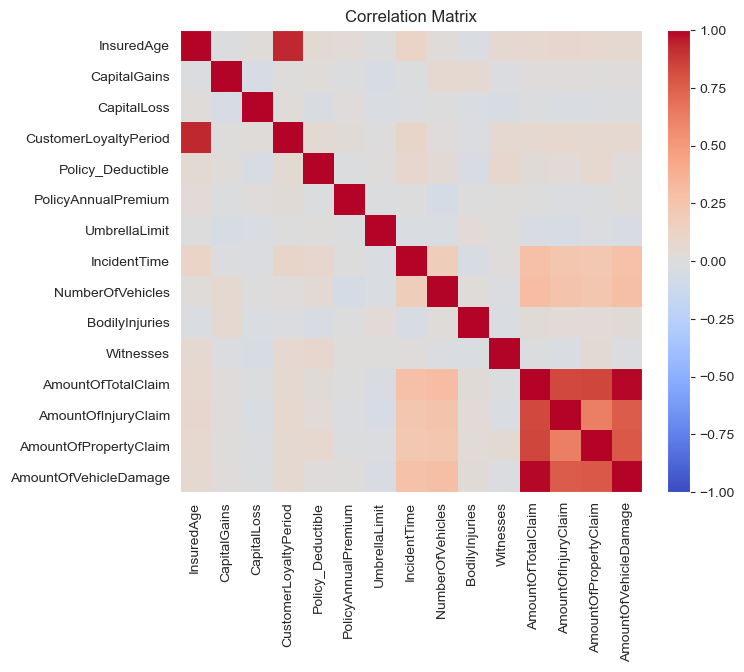

Total features retained for Pipeline: 29


In [67]:
# 1. Compute correlation (Check for multicollinearity)
corr = X.select_dtypes('number').corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

plt.gca().set_aspect('equal')
plt.grid(False)

plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Matrix")
plt.show()

# List of redundant sub-claim features to remove
redundant_features = ['AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'AmountOfVehicleDamage']

# Drop them from your X variable
X = X.drop(columns=redundant_features)
print(f"Total features retained for Pipeline: {len(X.columns)}")

### Negative Umbrella limmits

"To handle logical inconsistencies in the UmbrellaLimit attribute without introducing bias, a custom FunctionTransformer was integrated into the pre-processing pipeline. This component identifies negative values—which are physically impossible in an insurance context—and casts them as null values (NaN). These are then handled by a SimpleImputer using a median strategy. This approach ensures that invalid data points are treated as missing information rather than influential outliers, preserving the integrity of the linear coefficients in the Logistic Regression model."

In [30]:
# Filter the dataframe for negative Umbrella Limits
negative_umbrella = data_merged[data_merged['UmbrellaLimit'] < 0]

# Display the count and the specific columns
print(f"Number of rows with UmbrellaLimit < 0: {len(negative_umbrella)}")

# Show the first few examples
negative_umbrella[['CustomerID', 'UmbrellaLimit', 'ReportedFraud_Numeric']].head()

# 1. Create a function to turn negative UmbrellaLimits into NaN
def treat_negative_as_nan(df):
    df = df.copy()
    if 'UmbrellaLimit' in df.columns:
        df.loc[df['UmbrellaLimit'] < 0, 'UmbrellaLimit'] = np.nan
    return df

Number of rows with UmbrellaLimit < 0: 34


### Building the "Master" Pipeline with Selection

In [349]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

# This ensures the 'Clean' data flows into the Imputer and Scaler
cleansing_step = FunctionTransformer(treat_negative_as_nan)

# A. Numerical Transformer (Impute + Scale)
numeric_transformer = Pipeline(steps=[
    ('cleanser', cleansing_step),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Categorical Transformer (Impute + One-Hot)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# C. Master Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# D. Create the 'Pre-Processing + Selection' Pipeline
# This ensures requirement 3.c (Feature Selection) is handled automatically
feature_selection_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif, k=20)) # Automatically pick top 20
])

Splitting the Data

In [350]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split successfully. Train: {len(X_train)}, Test: {len(X_test)}")

Data split successfully. Train: 23068, Test: 5768


Technique 1 - Logistic Regression

In [351]:
from sklearn.linear_model import LogisticRegression
# Give Fraud (1) four times as much importance as Genuine (0)
custom_weight = {0: 1, 1: 1}

# Bundle everything together
pipeline_lr = Pipeline(steps=[
    ('prep_and_sel', feature_selection_pipeline),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# TRAINING - This is where the protection happens!
pipeline_lr.fit(X_train, y_train)

print("Technique 1: Logistic Regression Pipeline trained without leakage.")

Technique 1: Logistic Regression Pipeline trained without leakage.


### Evaluation Metrics

--- Technique 1: Logistic Regression ---
Overall Accuracy: 80.74%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4211
           1       0.62      0.75      0.68      1557

    accuracy                           0.81      5768
   macro avg       0.76      0.79      0.77      5768
weighted avg       0.82      0.81      0.81      5768



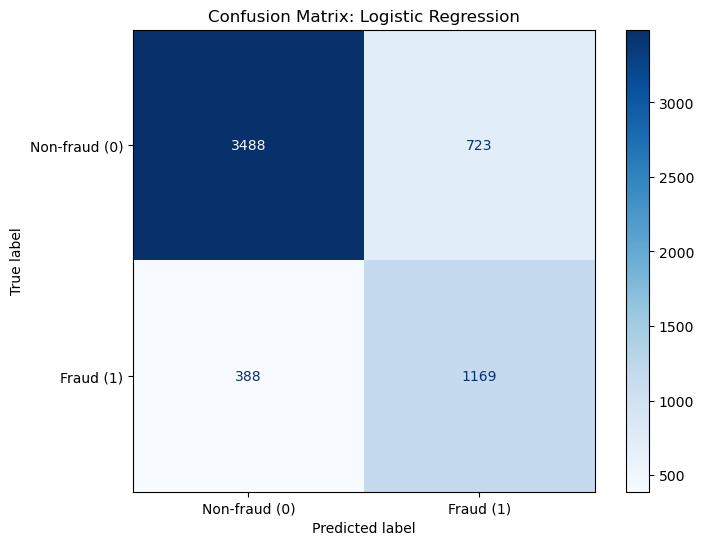

In [352]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# 1. Make predictions using the pipeline
y_pred = pipeline_lr.predict(X_test)

# 2. Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"--- Technique 1: Logistic Regression ---")
print(f"Overall Accuracy: {acc:.2%}")

# 3. Detailed Classification Report
# This gives you Precision, Recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4. Generate the Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-fraud (0)', 'Fraud (1)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

### Checking class imbalance


--- Class Imbalance Check (Percentage) ---
ReportedFraud_Numeric
0    73.002497
1    26.997503
Name: proportion, dtype: float64


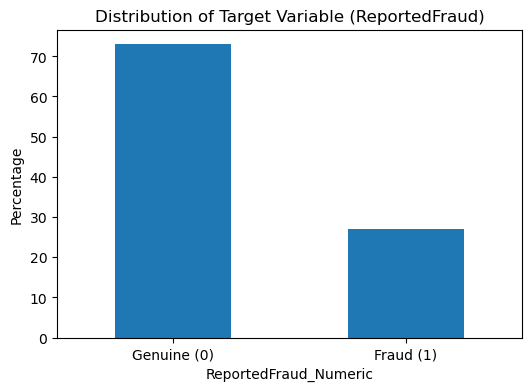

In [353]:
# Check for class imbalance
imbalance_check = data_merged['ReportedFraud_Numeric'].value_counts(normalize=True) * 100

print("\n--- Class Imbalance Check (Percentage) ---")
print(imbalance_check)

# Visualize the imbalance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
imbalance_check.plot(kind='bar')
plt.title('Distribution of Target Variable (ReportedFraud)')
plt.xticks([0, 1], ['Genuine (0)', 'Fraud (1)'], rotation=0)
plt.ylabel('Percentage')
plt.show()

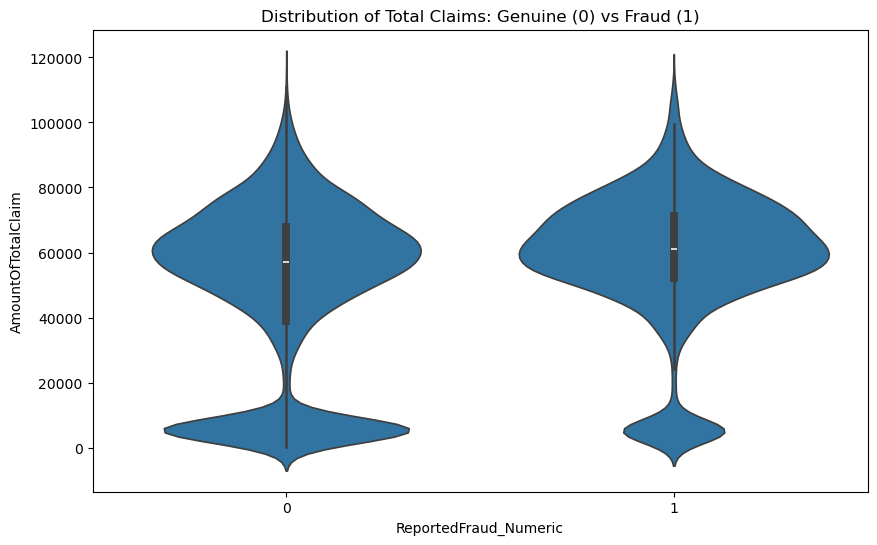

In [354]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check how Total Claim varies by Fraud status
plt.figure(figsize=(10, 6))
sns.violinplot(x='ReportedFraud_Numeric', y='AmountOfTotalClaim', data=data_merged)
plt.title('Distribution of Total Claims: Genuine (0) vs Fraud (1)')
plt.show()

## 4. Technique 1
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 4.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 5. Technique 2
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 5.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 6. Comparison of metrics performance for testing

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Use of nested cross-validation for both techniques to deal with overfitting model selection and model comparison
- Use appropriate metrics for the testing set
- Use an appropriate model selection visualisation curve (ROC, PR, etc.) that is suitable for the problem at hand
- Checking for overfitting

## 7. Final recommendation of the best model

**Create a new subheading for each item you discuss from the following items.**

- Technical perspective- overfitting discussion, complexity and efficiency
- Business perspective- results interpretation, relevance and balance with a technical perspective

## 8. Conclusion

**Create a new subheading for each item you discuss from the following items.**

- What has been successfully accomplished and what has not
- Reflect back on the analysis and see what you could have done differently if you were to do the project again
- Add a wish list of future work that you would do to take the project forward


In [32]:
import json

def count_words(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)

    markdown_word_count = 0
    code_word_count = 0

    for cell in data['cells']:
        # Extract the text content from the cell
        content = "".join(cell['source'])
        words = content.split()

        if cell['cell_type'] == 'markdown':
            markdown_word_count += len(words)
        elif cell['cell_type'] == 'code':
            code_word_count += len(words)

    print(f"--- Notebook Word Count: {filepath} ---")
    print(f"Markdown Words (Report text): {markdown_word_count}")
    print(f"Code Words (Scripts/Variables): {code_word_count}")
    print(f"Total Words: {markdown_word_count + code_word_count}")

# Make sure to save your notebook (Ctrl+S) before running this!
count_words('Assessment.ipynb')

--- Notebook Word Count: Assessment.ipynb ---
Markdown Words (Report text): 1276
Code Words (Scripts/Variables): 1177
Total Words: 2453
